Do all data preprocessing outside of model scope

Also if all targets are same scale, only need one amplitude constant

Try different priors, reasonable ones help a lot

Especially if it's ending up in unreasonable parts of space

Henry thinks you can put priors on those transformed parameters

Also probably possible to fit parameters in different sections

So fit sigma first, etc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path_sim = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n5500_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path = '/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# PyMC 

## ADVI

In [2]:
#df_sim = pd.read_csv(df_path_sim)
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)

In [9]:
model = sfp.monte_carlo.setup_model(df_sim)

In [10]:
with model:
    advi=pm.ADVI()
    advi_fit = advi.fit(10000, obj_optimizer=pm.adam(learning_rate=.01), )#more_replacements=map_tensor_batch,)# callbacks=[tracker])

Average Loss = -5,401.4: 100%|██████████| 10000/10000 [00:05<00:00, 1704.01it/s]
Finished [100%]: Average Loss = -5,401.4


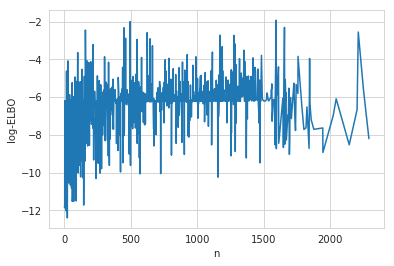

In [11]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [12]:
advi_trace = advi_fit.sample(500)

In [13]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
voxel_norm,0.259179,0.004831,0.000194,0.249980,0.269167
sigma,0.995364,0.018782,0.000757,0.951151,1.026065
sf_ecc_slope,0.509445,0.008101,0.000373,0.492128,0.523162
sf_ecc_intercept,0.448265,0.028002,0.001332,0.394971,0.500991


/users-lcv/broderick/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


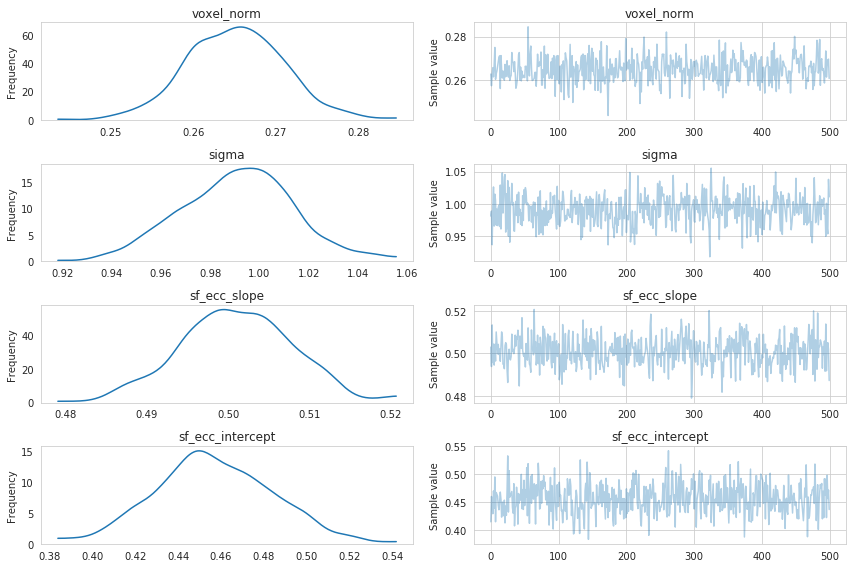

In [157]:
pm.traceplot(advi_trace);#, ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

## MCMC

In [14]:
df_sim = sfp.simulate_data.main('iso', 'full', False, sigma=1, sf_ecc_intercept=.5, sf_ecc_slope=.5, num_voxels=100, noise_source_path=df_path, noise_level=1)
df_sim.to_csv('test.csv')

In [38]:
inference_data = sfp.monte_carlo.main('test.csv', n_chains=8, n_samples=500, save_path='test.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sf_ecc_intercept, sf_ecc_slope, sigma, voxel_norm]
Sampling 8 chains: 100%|██████████| 8000/8000 [00:06<00:00, 1232.74draws/s]
The acceptance probability does not match the target. It is 0.8834404058240792, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960706376917451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795208024442992, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903270491689225, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790188143032056, but should be close to 0.8. Try to increase the number of t

In [40]:
inference_data.posterior

<xarray.Dataset>
Dimensions:           (chain: 8, draw: 500)
Coordinates:
  * chain             (chain) int64 0 1 2 3 4 5 6 7
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
Data variables:
    voxel_norm        (chain, draw) float64 0.2638 0.269 ... 0.2672 0.2618
    sigma             (chain, draw) float64 0.9914 0.9874 ... 0.9791 1.008
    sf_ecc_slope      (chain, draw) float64 0.5218 0.4918 ... 0.4955 0.5279
    sf_ecc_intercept  (chain, draw) float64 0.3746 0.5357 ... 0.4515 0.4074
Attributes:
    created_at:                 2019-04-22T23:34:14.035253
    inference_library:          pymc3
    inference_library_version:  3.6
    first_level_results_path:   test.csv
    n_cores:                    8
    random_seed:                None
    df_filter_string:           None

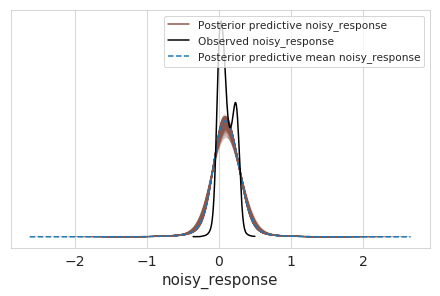

In [45]:
az.plot_ppc(inference_data);

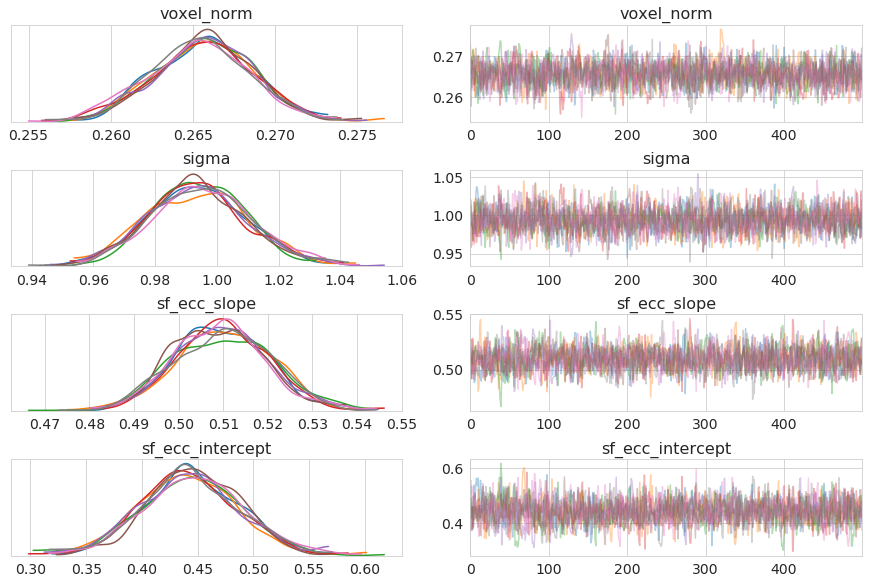

In [46]:
az.plot_trace(inference_data);